# Dog breed classification with cnn

### Preprocessing datas

In [4]:
# import all libraries

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
%timeit 2+2

KeyboardInterrupt: 

In [2]:
# creation of train, validation and test folders

import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size, validation_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('../data'):
        os.makedirs('../data')
    else:
        if not os.path.exists('../data/train'):
            os.makedirs('../data/train')
        if not os.path.exists('../data/validation'):
            os.makedirs('../data/validation')
        if not os.path.exists('../data/test'):
            os.makedirs('../data/test')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('../data/train', subdir)
        validation_subdir = os.path.join('../data/validation', subdir)
        test_subdir = os.path.join('../data/test', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)
            
        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)

        train_counter = 0
        validation_counter = 0
        test_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                elif random.uniform(0, 1) <= validation_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                else :
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(test_subdir, str(test_counter) + '.' + fileparts[1]))
                    test_counter += 1
                    

img_train_test_split('../data/images/', 0.7, 0.7)

In [5]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/train')
valid_files, valid_targets = load_dataset('../data/validation')
test_files, test_targets = load_dataset('../data/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../data/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 20580 total dog images.

There are 14531 training dog images.
There are 4232 validation dog images.
There are 1817 test dog images.


In [103]:
y = valid_targets[15]
results = sorted(enumerate(y), reverse=True, key=lambda x:x[1])
classes_ind=[x[0] for x in results]
classes = [dog_names[x] for x in classes_ind]

In [105]:
classes

['505-komondor', '620-Chihuahua', '782-Japanese_spaniel']

In [70]:
data = load_files('../data/train')

In [81]:
data['filenames'][4]

'../data/train/n02087394-Rhodesian_ridgeback/38.jpg'

In [72]:
type(data)

sklearn.utils.Bunch

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

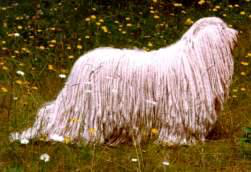

In [102]:
def show_img(num):
    img_path = valid_files[num]
    img = image.load_img(img_path)
    return img
show_img(15)

### Classification without data augmentation

#### Trying the cnn on a small part of the dataset

In [7]:
train_sample = train_files[0:1000]
train_targets_sample = train_targets[0:1000]
valid_sample = valid_files[0:400]
valid_targets_sample = valid_targets[0:400]

In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors_sample = paths_to_tensor(train_sample).astype('float32')/255
valid_tensors_sample = paths_to_tensor(valid_sample).astype('float32')/255


100%|██████████| 400/400 [00:01<00:00, 335.78it/s]


In [20]:
np.shape(train_tensors_sample)

(1000, 224, 224, 3)

In [9]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
pretrained_model.trainable = False

model = Sequential([pretrained_model,
                    Flatten(),
                    Dense(120, activation='softmax')])

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               3010680   
Total params: 17,725,368
Trainable params: 3,010,680
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 4

model.fit(train_tensors_sample, train_targets_sample, 
          validation_data=(train_tensors_sample, train_targets_sample),
          epochs=epochs, batch_size=20, verbose=2)

Train on 1000 samples, validate on 1000 samples
Epoch 1/4
 - 498s - loss: 7.4863 - accuracy: 0.0270 - val_loss: 1.1347 - val_accuracy: 0.7900
Epoch 2/4
 - 442s - loss: 0.5260 - accuracy: 0.8980 - val_loss: 0.0685 - val_accuracy: 0.9970
Epoch 3/4
 - 444s - loss: 0.0538 - accuracy: 0.9960 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 4/4
 - 444s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000


#### vgg16 

In [164]:
from PIL import ImageFile             
ImageFile.LOAD_TRUNCATED_IMAGES = True 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

  3%|▎         | 491/14420 [00:01<00:33, 411.21it/s]

100%|██████████| 3723/3723 [00:14<00:00, 258.63it/s]


In [165]:
from keras.callbacks import ModelCheckpoint, History

history = History()
checkpoint_filepath = '../data/checkpoint'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   verbose=1,
                                   save_best_only=True)

In [166]:
%%time
# specify the number of epochs that you would like to use to train the model.
epochs = 20

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, 
          batch_size=20, 
          verbose=2,
          callbacks = [model_checkpoint, history])

Train on 14420 samples, validate on 2437 samples
Epoch 1/20
 - 3560s - loss: 4.9589 - accuracy: 0.4349 - val_loss: 7.8486 - val_accuracy: 0.2630

Epoch 00001: val_loss improved from inf to 7.84860, saving model to ../data/checkpoint
Epoch 2/20
 - 3544s - loss: 1.1847 - accuracy: 0.7640 - val_loss: 7.4203 - val_accuracy: 0.2675

Epoch 00002: val_loss improved from 7.84860 to 7.42031, saving model to ../data/checkpoint
Epoch 3/20
 - 3546s - loss: 0.6266 - accuracy: 0.8553 - val_loss: 7.8203 - val_accuracy: 0.2799

Epoch 00003: val_loss did not improve from 7.42031
Epoch 4/20
 - 3590s - loss: 0.4782 - accuracy: 0.8872 - val_loss: 8.7823 - val_accuracy: 0.2507

Epoch 00004: val_loss did not improve from 7.42031
Epoch 5/20
 - 3607s - loss: 0.5126 - accuracy: 0.8882 - val_loss: 8.9512 - val_accuracy: 0.2618

Epoch 00005: val_loss did not improve from 7.42031
Epoch 6/20
 - 3827s - loss: 0.4965 - accuracy: 0.8943 - val_loss: 9.8778 - val_accuracy: 0.2556

Epoch 00006: val_loss did not improve 

### Cnn with data augmentation

In [167]:
# training image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import History 

batch_size = 16

# this is the augmentation configuration I will use for training
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

# This is the augmentation configuration I will use for testing/validation... just a rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# This is the generator which will read pictures found in my training subset
train_generator = train_datagen.flow_from_directory('../data/train/',
                                                    target_size = (224, 224),
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')

# This is the generator for validation data
validation_generator = test_datagen.flow_from_directory('../data/validation/',
                                                        target_size = (224, 224),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical')

Found 14420 images belonging to 120 classes.
Found 2437 images belonging to 120 classes.


In [1]:
x,y = train_generator.next()
test = x[15]
plt.imshow(test)

NameError: name 'train_generator' is not defined

In [168]:
from keras.callbacks import ModelCheckpoint, History

history = History()
checkpoint_augmentation = '../data/checkpoint_augmentation'
model_checkpoint_augmentation = ModelCheckpoint(filepath=checkpoint_augmentation,
                                                verbose=1,
                                                save_best_only=True)

In [169]:
%%time
model.fit_generator(train_generator,
                    epochs = 30,
                    validation_data = validation_generator,
                    callbacks = [model_checkpoint_augmentation, history],
                    verbose=2)

Epoch 1/30
 - 3704s - loss: 12.8014 - accuracy: 0.2596 - val_loss: 2.7200 - val_accuracy: 0.2573

Epoch 00001: val_loss improved from inf to 2.71996, saving model to ../data/checkpoint_augmentation
Epoch 2/30
 - 3659s - loss: 9.0285 - accuracy: 0.3304 - val_loss: 13.0687 - val_accuracy: 0.2868

Epoch 00002: val_loss did not improve from 2.71996
Epoch 3/30
 - 3658s - loss: 8.0821 - accuracy: 0.3491 - val_loss: 6.1390 - val_accuracy: 0.2913

Epoch 00003: val_loss did not improve from 2.71996
Epoch 4/30
 - 3736s - loss: 7.5232 - accuracy: 0.3681 - val_loss: 13.9761 - val_accuracy: 0.2987

Epoch 00004: val_loss did not improve from 2.71996
Epoch 5/30
 - 3635s - loss: 7.1920 - accuracy: 0.3870 - val_loss: 9.8625 - val_accuracy: 0.2840

Epoch 00005: val_loss did not improve from 2.71996
Epoch 6/30
 - 3638s - loss: 7.0727 - accuracy: 0.3874 - val_loss: 6.2316 - val_accuracy: 0.2872

Epoch 00006: val_loss did not improve from 2.71996
Epoch 7/30
 - 3635s - loss: 6.8344 - accuracy: 0.3941 - val_

In [24]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

output = vgg.output
output = Flatten()(output)
output = Dense(120, activation='softmax')(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [25]:
# Compiler le modèle 
from keras.optimizers import Adam

opt = Adam(lr=0.001)

vgg_model.compile(loss="categorical_crossentropy", 
                  optimizer=opt,
                  metrics=["accuracy"])


In [28]:
vgg_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [26]:
from keras.callbacks import ModelCheckpoint, History

history = History()
checkpoint_filepath = '../data/checkpoint'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   verbose=1,
                                   save_best_only=True)

In [29]:
%%time
vgg_model.fit_generator(train_files_sample, train_targets_sample,
                        epochs = 10,
                        callbacks = [model_checkpoint, history],
                        verbose=2)

Epoch 1/10


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()